# Titanic Dataset Exploration
1.  Introduction
2.  Exploring the Data
3.  Plotting the Data

# Introduction

Hello. My name is Evan Freeman. I'm currently just messing around with pandas, matplotlib, and seaborn to improve my data analysis and visualization skills.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML




pd.options.display.max_columns = None
pd.options.display.max_rows = 30



titanic = pd.read_csv('D:/code/Data/titanic/train.csv')

# Exploring the Data

In [2]:
# This line can be used if you want to view the data as trues and falses
#titanic.Survived = titanic.Survived.apply(lambda x : True if x == 1 else False)

display(titanic)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Here's some explanations about the data, taken from the datafiles

Data Dictionary:  


Variable	Definition	Key  
survival	Survival	0 = No, 1 = Yes  
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex	Sex	  
Age	Age in years	 
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  

Variable Notes  
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

Let's clean up the missing data:

# Plotting the Data

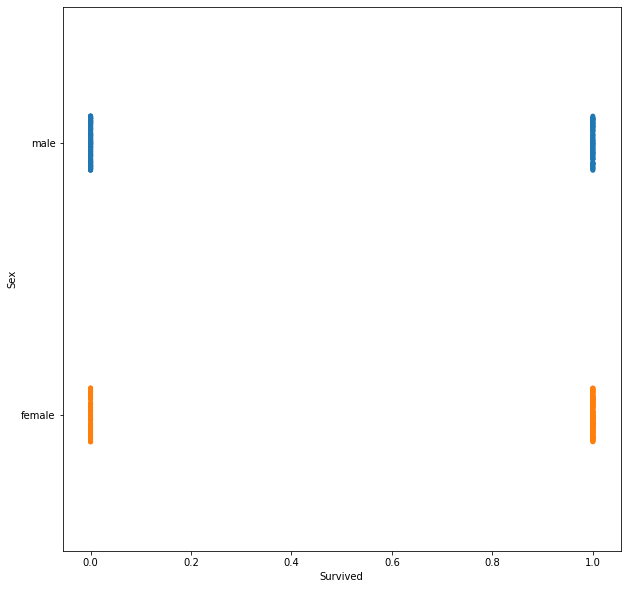

In [3]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'Survived', y = 'Sex', data = titanic)
plt.show()

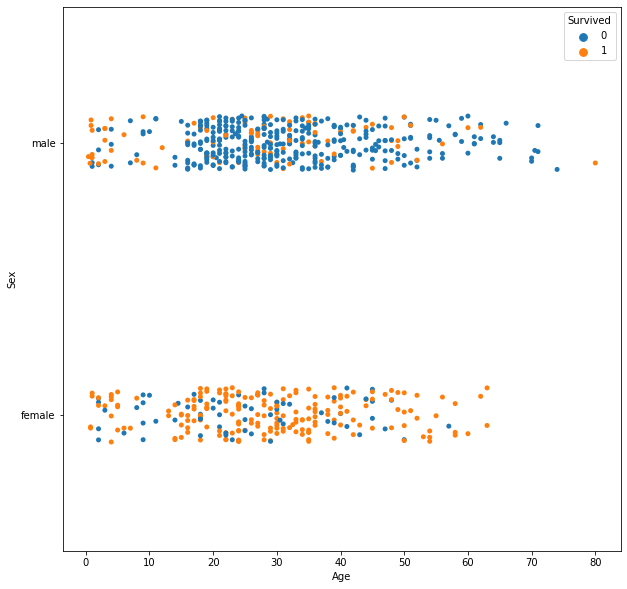

In [4]:
plt.figure(figsize = (10, 10))
sns.stripplot(x = 'Age', y = 'Sex', hue = 'Survived', data = titanic)
plt.show()

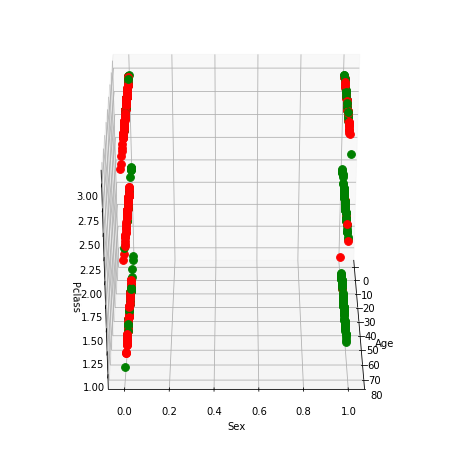

In [5]:
xs = titanic['Age']
ys = titanic['Sex'].apply(lambda x : 0 if x =='male' else 1)
zs = titanic['Pclass']
label = titanic['Survived']
data = zip(xs, ys, zs, label)

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')

for x, y, z, l in data:
    if l == 0:
        color = 'red'
    else:
        color = 'green'
    ax.scatter(x, y, z, s=60, label = l, c = color)

ax.view_init(30, 185)
ax.set_xlabel('Age')
ax.set_ylabel('Sex')
ax.set_zlabel('Pclass')

def animate(i):
    ax.view_init(30, i)
    return plt.draw()

anim = animation.FuncAnimation(fig, animate, frames = 360, interval = 20, blit = False)
    
HTML(anim.to_html5_video())
#HTML(anim.to_jshtml())

Wow! What a beautiful graph I've made!!  

From this, we can already draw a few conclusions:  

1. Seems like Men died more, 2nd and 3rd class folks died more, and 

# Feature Generation

Most of the features appear good to go. However, there is one feature that we can extract: the title of the person: Mr., Mrs., Dr., etc...

# Data Cleaning

Let's check missing numbers, impute where needed, and change male / female to 0, 1

# Correlation Matrix



# Principal Component Analysis (PCA)

For multidimensional data, one very useful technique is to reduce the dimension, by looking at the linear combination of features which explains the most variance, removing it, and then continuing until all variance is explained in terms of orthogonal basis vectors.